In [1]:
import numpy as np
import os
import tensorflow as tf
import shutil
import pickle
import gzip
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

2024-03-16 22:05:13.993237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 22:05:13.993348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 22:05:14.161173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Preprocessing**

In [2]:
data, labels, training_data = [], [], []
data_dir = '/kaggle/input/braille-all/augm_data/augm_data'

for char_dir in os.listdir(data_dir):
    char_path = os.path.join(data_dir, char_dir)
    for im in os.listdir(char_path):
        img = image.load_img(os.path.join(char_path, im), target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        x /= 255.0
        training_data.append([x, char_dir])
        
np.random.shuffle(training_data)

In [3]:
for im, label in training_data:
    data.append(im)
    labels.append(label)
    
X = np.array(data)
y = np.array(labels)

In [4]:
len(training_data), len(X), len(y)

(6519, 6519, 6519)

In [6]:
with gzip.open('preprocessed_data.pkl.gz', 'wb') as f:
   pickle.dump({'data': X, 'labels': y}, f)

In [7]:
#with gzip.open('/kaggle/working/preprocessed_data.pkl.gz', 'rb') as f:
#    loaded_data = pickle.load(f)
    
#len(loaded_data['data']), len(loaded_data['labels'])

(6519, 6519)

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=64)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [12]:
checkpoint_cb = ModelCheckpoint('checkpoints.weights.h5', 
                                save_best_only=True,
                                save_weights_only=True, 
                                verbose=1)

reduce_lr_cb = ReduceLROnPlateau(patience=10, verbose=1)

early_stopping_cb = EarlyStopping(patience=20, 
                                  restore_best_weights=True,
                                  start_from_epoch=20,
                                  verbose=1)

In [13]:
base_model = DenseNet201(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-40:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0015))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(64, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
history = model.fit(x_train, y_train, 
                    epochs=1000, 
                    validation_split=0.2, 
                    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb])

Epoch 1/1000


I0000 00:00:1710627016.338333     374 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710627016.461417     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.0276 - loss: 4.6929

W0000 00:00:1710627071.448661     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710627090.394907     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 3.99745, saving model to checkpoints.weights.h5


W0000 00:00:1710627121.840010     375 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 820ms/step - accuracy: 0.0276 - loss: 4.6910 - val_accuracy: 0.0796 - val_loss: 3.9975 - learning_rate: 0.0010
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0920 - loss: 3.6807
Epoch 2: val_loss improved from 3.99745 to 2.83067, saving model to checkpoints.weights.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.0923 - loss: 3.6783 - val_accuracy: 0.1822 - val_loss: 2.8307 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2791 - loss: 2.5274
Epoch 3: val_loss improved from 2.83067 to 1.78139, saving model to checkpoints.weights.h5
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.2794 - loss: 2.5261 - val_accuracy: 0.4899 - val_loss: 1.7814 - learning_rate: 0.0010
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.4138 - loss: 1.8767
Epoch 4: val_loss improved from 1.78139 to 1.12195, saving model to checkpoints.weights.h5
131/131 ━━━━━━━━━━━━━━━━

# Evaluate the model

## Learning curves

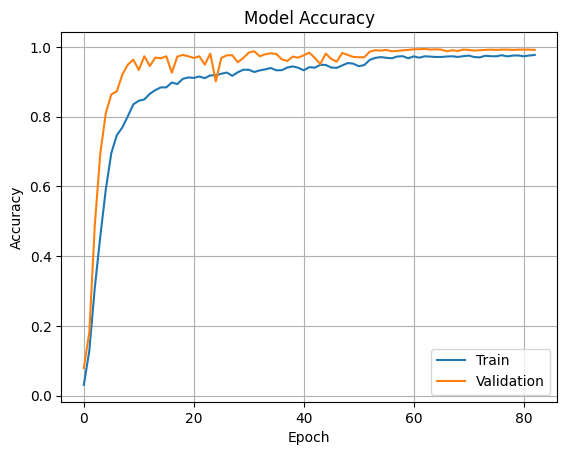

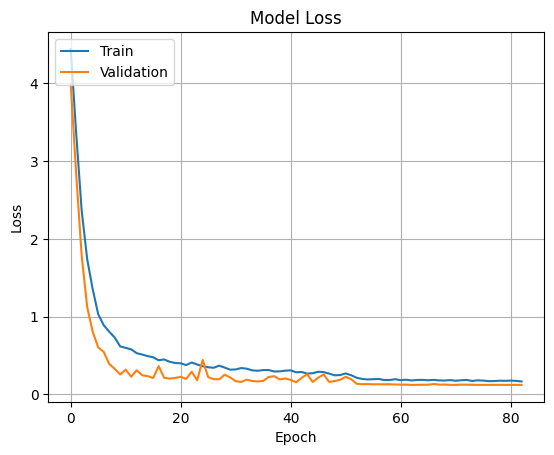

In [15]:
# Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.show()

# Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

## Training accuracy, recall and precision

In [23]:
class_names = [label for label in os.listdir(data_dir)]

In [17]:
model.evaluate(x_train, y_train)

163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 315ms/step - accuracy: 0.9998 - loss: 0.0956


W0000 00:00:1710629220.469961     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.10005952417850494, 0.9988494515419006]

In [16]:
model.evaluate(x_test, y_test)

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 843ms/step - accuracy: 0.9895 - loss: 0.1294


W0000 00:00:1710629147.314548     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.12867097556591034, 0.9900306463241577]

In [19]:
y_pred_probs_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)
y_true_train = np.argmax(y_train, axis=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step


In [20]:
precision = precision_score(y_true_train, y_pred_train, average='macro')
print('Training precision: %.3f' % precision)

Training precision: 0.999


In [21]:
recall = recall_score(y_true_train, y_pred_train, average='macro')
print('Training recall: %.3f' % recall)

Training recall: 0.999


In [25]:
report = classification_report(y_true_train, y_pred_train, target_names=class_names)

print(report)

              precision    recall  f1-score   support

      110010       0.99      1.00      0.99        84
      000001       1.00      1.00      1.00        80
      000110       1.00      1.00      1.00        84
      111001       1.00      1.00      1.00        82
      110111       1.00      1.00      1.00        80
      001101       1.00      1.00      1.00        84
      010000       1.00      1.00      1.00        82
      100000       1.00      1.00      1.00        82
      111111       1.00      1.00      1.00        80
      100001       1.00      1.00      1.00        80
      100111       1.00      1.00      1.00        80
      101011       1.00      1.00      1.00        80
      001000       1.00      1.00      1.00        80
      101100       1.00      1.00      1.00        80
      100100       1.00      1.00      1.00        80
      110101       1.00      1.00      1.00        82
      010101       1.00      0.99      0.99        80
      011000       1.00    

## Test accuracy, recall and precision

In [26]:
y_pred_probs_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step


W0000 00:00:1710629772.941329     374 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
precision = precision_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % precision)

Test precision: 0.990


In [28]:
recall = recall_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % recall)

Test precision: 0.990


In [29]:
report = classification_report(y_true_test, y_pred_test, target_names=class_names)

print(report)

              precision    recall  f1-score   support

      110010       1.00      0.90      0.95        21
      000001       0.91      1.00      0.95        20
      000110       0.95      1.00      0.98        21
      111001       1.00      1.00      1.00        20
      110111       1.00      1.00      1.00        20
      001101       1.00      1.00      1.00        21
      010000       1.00      0.95      0.97        20
      100000       1.00      1.00      1.00        20
      111111       0.95      1.00      0.98        20
      100001       1.00      0.95      0.97        20
      100111       1.00      1.00      1.00        20
      101011       1.00      1.00      1.00        20
      001000       1.00      1.00      1.00        20
      101100       1.00      1.00      1.00        20
      100100       0.95      1.00      0.98        20
      110101       1.00      1.00      1.00        20
      010101       1.00      0.95      0.97        20
      011000       1.00    

# Save the model and its metadata

In [30]:
# h5 format

model.save('custom_data_model.h5')

In [42]:
# Saving the metadata

metadata = {
    "author": "Ali ELneklawy, Nada Gamal, Nada Tarek",
    "description": "A model trained on our custom data",
    "date": "2024-03-17",
    "tensorflow_version": tf.__version__ # Include the TensorFlow version used to save the model
}

metadata_path = '/kaggle/working/metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f)

In [43]:
metadata_path = "/kaggle/working/metadata.json"

with open(metadata_path, 'r') as f:
    loaded_metadata = json.load(f)

print(loaded_metadata)

{'author': 'Ali ELneklawy, Nada Gamal, Nada Tarek', 'description': 'A model trained on our custom data', 'date': '2024-03-17', 'tensorflow_version': '2.15.0'}


In [35]:
# tf version used to save the model

print(tf.__version__)

2.15.0


In [1]:
!pip freeze

absl-py==1.4.0
accelerate==0.27.2
access==1.1.9
affine==2.4.0
aiobotocore==2.11.2
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1701099469104/work
aiohttp-cors==0.7.0
aioitertools==0.11.0
aiorwlock==1.3.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.19.0
albumentations==1.4.0
alembic==1.13.1
altair==5.2.0
annotated-types @ file:///home/conda/feedstock_root/build_artifacts/annotated-types_1696634205638/work
annoy==1.17.3
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1702909220329/work
apache-beam==2.46.0
aplus==0.11.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1699370045702/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array-record==0.5.0
arrow @ file:///home/conda/fe

In [48]:
# All enviroment varaiables

print(os.environ)

environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.1.0.26-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'TENSORFLOW_IO_VERSION': '0.35.0', 'NV_NVML_DEV_VERSION': '12.1.55-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn8', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.17.1-1+cuda12.1', 'KMP_WARNINGS': '0', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.17.1-1', 'CUDA_MINOR_VERSION': '1', 'HOSTNAME': '7484790c3ed0', 'DL_ANACONDA_HOME': '/opt/conda', 'NODE_OPTIONS': '--max-old-space-size=4096', 'KAGGLE_DATA_PROXY_TOKEN': 'eyJhbGciOiJBMTI4S1ciLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0.tTeq0F5JWMbaaPmzrdvab5jO6P5Q3NplRYm-cDyHPeLW5Ctj-2W45g.56uMdKq3dcvhM2kdMrIxZQ.bJy1-fyB_QsK8l4U_Z3ZdKHwb67v8n-B4kZ9je1nbg3Oz4IO68HFQW-QpnrCgd_gTee5hd7V8YZZVmlua3cKRR9Lsz4EzZk8mWckDuXSNc-wQL3PFtsAyy5QGaEYxRuYUxJyQPueR-wzIbECYMAW6j5B646YCkwD8gIdMxD3vtETE6aZS_n7icn2cXpYcuNkXzDugBMSSbcNzHNDF4_nvD_p2-571DWNop4-4CE75YiFswY1Or1WEGAFAoxTbAhVJLKvZDCf84O8h7jQTgbQhEJH9OegO4H0V-Q0vb9yT8FC3P60-ddpYh92VLEx0v0q.-VDPekkbNaRM8ZHx5L7bJA', 'NVIDIA_REQUIRE_CUDA': '

# Delete all files in working directory

In [5]:
working_directory = '/kaggle/working'

for file in os.listdir(working_directory):
    file_path = os.path.join(working_directory, file)

    if os.path.isfile(file_path):
        os.remove(file_path)

print("All files in the working directory deleted.")

All files in the working directory deleted.
